## 整理
### 癌症域标记|癌症相关基因集合|验证|应用


In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from matplotlib.colors import ListedColormap
import h5py
import os
import glob
import random
import numpy as np

In [3]:
'''计算lcczscore'''
# 读取背景网络
def openPPI(filename):
    '''
        打开PPI
        文件格式 gene1_name gene1_id gene2_name gene2_id
        返回值：网络[节点是gene name]
    '''
    G = nx.Graph()
    a=open(filename,"r")
    next(a)

    for i in a:
        n=i.strip().split("\t")
        G.add_edge(n[0],n[3])
        G.add_node(n[0])
        G.add_node(n[3])
    a.close()
    return G

# 计算最大连通分支
def Lcc(G,genename):
    '''
        输入图网络和一个列表，计算最大连通分支lcc
        G：图，这里图中的节点是基因name
        genename：用于计算lcc的genename列表
    '''

    g = nx.subgraph(G,genename)
    if len(genename)==0:
        largest = 0
        l = []
        return l,largest
    else:
        try:
            l = max(nx.connected_components(g),key=len)  #如果随机选取的gene没有连通分支的话，会报错，添加判断条件
            largest = len(l)     #最大联通分支
        except ValueError as e:
            l = genename[0]    # 假设genename列表中的第一个基因为最大连通分支
            largest = 1        #设置最大联通分支数为1
        return list(l),largest
    
def Lcc_mean(g,genelist,ran):
    '''
    每次从网络g的所有基因中随机选择genelist数量的gene，计算均值和标准差
    g:背景网络
    genelist：
    ran：随机次数
    返回：表达值之和、表达值均值的多次随机的均值和标准差
    '''

    all_genes = g.nodes()  # 背景网络中的gene

    #做随机
    l_list = []         #lcc列表
    for j in range(ran):
        black_nodes = random.sample(all_genes,len(genelist))
        l,largest_ran = Lcc(g,black_nodes)
        l_list.append(largest_ran)

    #计算lcczscore
    lcc_mean = np.mean(l_list)
    lcc_std  = np.std(l_list)

    return lcc_mean,lcc_std

# 计算lcczscore
def lccZscore(Lcc,lcc_mean,lcc_std):
    if lcc_std == 0:
        zscore = 0
    else:
        zscore = (Lcc - lcc_mean)/lcc_std
        zscore = round(zscore,6)
    return zscore
    
G = openPPI(r"E:\00_CeSOP\data\network(process_id).txt")

In [4]:
# 打印h5py文件每个组或数据集的名称
def print_structure(name, obj):
    
    print(f"Name: {name}")
    
    if isinstance(obj, h5py.Group):  # 如果是一个组
        print(f"  Group: {name}")
        for key in obj.keys():  # 遍历组中的子项
            print(f"    Subgroup: {key}")
    elif isinstance(obj, h5py.Dataset):  # 如果是一个数据集
        print(f"  Dataset: {name}, Shape: {obj.shape}, Dtype: {obj.dtype}")


### 1. 乳腺癌

#### 1.1 癌症相关的基因

In [17]:
# https://fantom.gsc.riken.jp/cat/v1/#/traits

# 读取文件文件夹下指定格式的文件
folder_path = r"E:\spatial-domain\data\BRCA\disease data"
file_extension = '.tsv'
# 使用glob模块查找匹配的文件
files = glob.glob(os.path.join(folder_path, '*' + file_extension))

for file in files:

    df = pd.read_csv(file, sep='\t')
    disease_genes = list(df["geneName"])
    l,lcc = Lcc(G,disease_genes)
    lcc_mean,lcc_std = Lcc_mean(G,disease_genes,100)
    lcczscore = lccZscore(lcc,lcc_mean,lcc_std)

    filename = str(os.path.basename(file))
    dataname = filename.split(".")[0]
    print(dataname,len(disease_genes),lcc,lcczscore)

Abnormality of the breastHP_0000769 71 6 2.733967
Breast DiseasesMESH_D001941 50 4 2.483741
breast_cancer_DOID_1612 985 297 -0.865703
Breast_carcinoma_HP_0003002 560 113 0.575791
Breast_Neoplasms_MESH_D001943 323 35 0.883933
female breast cancerDOID_0050671 16 4 7.533953



## 读取空间转录组数据


In [5]:
h5_file = r"E:\spatial-domain\data\BRCA\10x visium BRCA\filtered_feature_bc_matrix.h5"
# 打开HDF5文件
with h5py.File(h5_file, 'r') as f:
    f.visititems(print_structure)

Name: matrix
  Group: matrix
    Subgroup: barcodes
    Subgroup: data
    Subgroup: features
    Subgroup: indices
    Subgroup: indptr
    Subgroup: shape
Name: matrix/barcodes
  Dataset: matrix/barcodes, Shape: (3798,), Dtype: |S18
Name: matrix/data
  Dataset: matrix/data, Shape: (21352329,), Dtype: int32
Name: matrix/features
  Group: matrix/features
    Subgroup: _all_tag_keys
    Subgroup: feature_type
    Subgroup: genome
    Subgroup: id
    Subgroup: name
Name: matrix/features/_all_tag_keys
  Dataset: matrix/features/_all_tag_keys, Shape: (1,), Dtype: |S6
Name: matrix/features/feature_type
  Dataset: matrix/features/feature_type, Shape: (36601,), Dtype: |S15
Name: matrix/features/genome
  Dataset: matrix/features/genome, Shape: (36601,), Dtype: |S6
Name: matrix/features/id
  Dataset: matrix/features/id, Shape: (36601,), Dtype: |S15
Name: matrix/features/name
  Dataset: matrix/features/name, Shape: (36601,), Dtype: |S17
Name: matrix/indices
  Dataset: matrix/indices, Shape: (21

In [ ]:
### 10x visium BRCA annot_type(4) --------  Abnormality of the breast（HP_0000769）

In [6]:
from scipy.sparse import csr_matrix

h5_file = r"E:\spatial-domain\data\BRCA\10x visium BRCA\filtered_feature_bc_matrix.h5"

with h5py.File(h5_file, 'r') as f:
    data = f['matrix']['data'][:]
    indices = f['matrix']['indices'][:]
    indptr = f['matrix']['indptr'][:]
    genes_name = [str(x).split("'")[1] for x in f['matrix']['features']['name'][:]]
    
    # 假设矩阵有N行和M列，你可以从indptr的长度推算出行数
    n_rows = len(indptr) - 1  # 行数等于indptr长度减去1
    n_cols = len(genes_name)
    # 重建CSR矩阵
    sparse_matrix = csr_matrix((data, indices, indptr), shape=(n_rows, n_cols))  # 列数可以通过columns获取
    matrix = pd.DataFrame(sparse_matrix.toarray()) 
    matrix.columns = genes_name
    print(matrix)

      MIR1302-2HG  FAM138A  OR4F5  AL627309.1  AL627309.3  AL627309.2  \
0               0        0      0           0           0           0   
1               0        0      0           0           0           0   
2               0        0      0           0           0           0   
3               0        0      0           0           0           0   
4               0        0      0           0           0           0   
...           ...      ...    ...         ...         ...         ...   
3793            0        0      0           0           0           0   
3794            0        0      0           0           0           0   
3795            0        0      0           0           0           0   
3796            0        0      0           0           0           0   
3797            0        0      0           0           0           0   

      AL627309.5  AL627309.4  AP006222.2  AL732372.1  ...  AC133551.1  \
0              0           0           0          

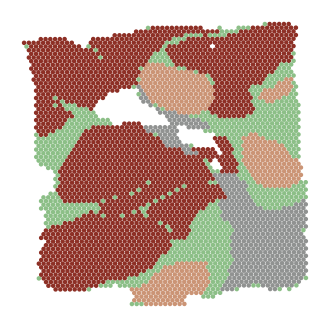

In [11]:
import matplotlib.colors as mcolors
metadata = pd.read_csv(r'E:\spatial-domain\data\BRCA\10x visium BRCA\metadata.tsv', sep='\t')
labels = metadata['annot_type']

# 标签到数字的映射
label_map = {'Invasive': 0, 'Tumor': 1, 'Surrounding tumor': 2, 'Healthy': 3}
numeric_labels = np.array([label_map[label] for label in labels])

# 定义颜色映射
cmap = mcolors.ListedColormap(['#8D2F25', '#CB9475', '#8CBF87', '#909291'])

plt.figure(figsize=(4, 4))

# 绘制散点图
scatter = plt.scatter(metadata['scaled_x'], metadata['scaled_y'], c=numeric_labels, cmap=cmap, s=5)

# 自定义图例
# 为每个类别手动创建一个图例条目
# handles = []
# for label, color in label_map.items():
#     handles.append(plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=cmap(color), markersize=10, label=label))
# 
# # 显示图例
# plt.legend(handles=handles,borderaxespad=0.1, fontsize=12, frameon=False, bbox_to_anchor=(1, 0.75))

plt.grid(False)
plt.axis('off')
# 保存图像为 PNG 文件
plt.savefig(r'E:\spatial-domain\figures\BRCA_spatial_domain.png', format='png', dpi=300, bbox_inches='tight')
plt.show()

In [30]:
# 使用pandas读取疾病相关的基因文件
df = pd.read_csv(r'E:\spatial-domain\data\BRCA\disease data\Abnormality of the breastHP_0000769.tsv', sep='\t')
disease_genes = list(df["geneName"])
l1,lcc1 = Lcc(G,disease_genes)
a = list(set(matrix.columns)& set(disease_genes))
l2,lcc2 = Lcc(G,a)
lcc_mean,lcc_std = Lcc_mean(G,a,100)
lcczscore = lccZscore(lcc2,lcc_mean,lcc_std)
lcc1,lcc2,lcczscore

(6, 5, 4.720204)

In [24]:
# 使用pandas读取疾病相关的基因文件
df = pd.read_csv(r'..\data\BRCA\disease data\Abnormality of the breastHP_0000769.tsv', sep='\t')
disease_genes = list(df["geneName"])

# 遍历每一个spot
result_list = []
for index, row in matrix.iloc[:].iterrows():
    express_genes = row[row != 0].index.tolist()  # 获取非零值的列名
    disease_express_genes = list(set(disease_genes)&set(express_genes))
    l,lcc = Lcc(G,disease_express_genes)
    
    express_network_genelist = list(set(express_genes) & set(list(G.nodes())))   # 有表达的网络基因   
    g = nx.subgraph(G,express_network_genelist)    # 构建有表达的子网络
    lcc_mean,lcc_std = Lcc_mean(g,disease_express_genes,100)
    
    lcczscore = lccZscore(lcc,lcc_mean,lcc_std)

    result_list.append([len(express_genes),len(disease_express_genes),lcc,lcczscore])
    print(index,len(express_genes),len(disease_express_genes),lcc,lcczscore)

df_singcell = pd.DataFrame(result_list)
df_singcell.columns = ["#expressedGenes","#expressedDiseaseGenes","lcc","lcczscore"]
df_singcell.to_csv(r"..\results\BRCA\10x visium BRCA-HP_0000769.csv", index=False)

0 4408 7 2 3.007114
1 9001 15 3 1.61578
2 2377 3 1 -0.204124
3 5846 13 3 3.841749
4 8691 16 4 4.137648
5 7240 11 1 -0.423547
6 6342 9 3 4.300232
7 9279 15 3 3.131935
8 7557 10 1 -0.423547
9 5721 10 3 3.766127
10 5502 9 2 1.271715
11 7866 12 2 1.832261
12 1651 2 1 0
13 7808 16 4 4.079301
14 7390 11 3 4.737271
15 1399 1 1 0
16 1401 2 1 -0.142857
17 8048 16 3 1.716048
18 2529 3 1 -0.100504
19 2797 2 1 0
20 9100 14 3 2.779091
21 3931 5 1 -0.261488
22 6983 12 2 1.386771
23 5608 9 2 1.962991
24 2985 6 1 -0.294884
25 2649 3 1 -0.204124
26 9227 16 3 2.352859
27 6050 11 2 1.555032
28 4452 5 1 -0.229416
29 4718 5 1 -0.204124
30 3592 6 1 -0.281939
31 1872 4 1 -0.274352
32 4560 7 2 4.358899
33 5427 12 2 1.572427
34 3295 6 1 -0.333333
35 4643 8 3 5.728716
36 4938 6 2 5.686241
37 2478 2 1 0
38 7336 12 2 1.942385
39 3496 5 1 -0.252646
40 7208 13 3 2.943628
41 6083 13 2 1.439699
42 7847 14 3 3.268233
43 7789 16 3 2.666667
44 7134 14 2 1.044185
45 1906 3 1 -0.175863
46 8152 14 3 3.362866
47 4155 9 1 -0

In [23]:
import matplotlib.colors as mcolors
metadata = pd.read_csv(r'E:\spatial-domain\data\BRCA\10x visium BRCA\metadata.tsv', sep='\t')
labels = metadata['ground_truth']
labels

0       Tumor_edge_5
1              IDC_4
2          Healthy_1
3              IDC_3
4              IDC_4
            ...     
3793           IDC_7
3794           IDC_4
3795           IDC_4
3796    Tumor_edge_2
3797    Tumor_edge_1
Name: ground_truth, Length: 3798, dtype: object

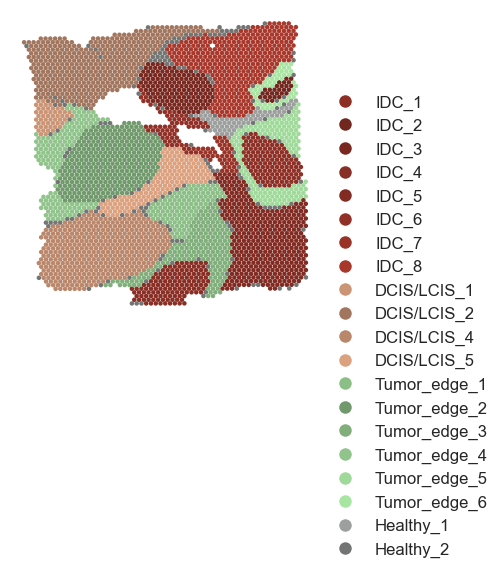

In [27]:
import matplotlib.colors as mcolors
metadata = pd.read_csv(r'E:\spatial-domain\data\BRCA\10x visium BRCA\metadata.tsv', sep='\t')
labels = metadata['ground_truth']

# 标签到数字的映射
# ['Invasive','Tumor','Surrounding tumor','Healthy']
label_map = {'IDC_1': 0, 'IDC_2': 1, 'IDC_3': 2, 'IDC_4': 3, 'IDC_5': 4, 'IDC_6': 5, 'IDC_7': 6, 'IDC_8': 7, 
             'DCIS/LCIS_1': 8, 'DCIS/LCIS_2': 9,'DCIS/LCIS_4': 10,'DCIS/LCIS_5': 11,
             'Tumor_edge_1': 12, 'Tumor_edge_2': 13, 'Tumor_edge_3': 14, 'Tumor_edge_4': 15, 'Tumor_edge_5': 16, 'Tumor_edge_6': 17, 
             'Healthy_1': 18,'Healthy_2': 19}
numeric_labels = np.array([label_map[label] for label in labels])

# 定义颜色映射
cmap = mcolors.ListedColormap(['#8D2F25', '#71261e','#792820','#892e24','#812b22','#913026','#993328','#a9382c',
                               '#CB9475', '#a2765e','#ba876b','#dca17f',
                               '#8CBF87', '#70996c','#80af7b','#90c48b','#a0da9a','#a8e5a2',
                               '#9c9f9d','#737574'])
# 标签到数字的映射
label_encoder = LabelEncoder()
numeric_labels = label_encoder.fit_transform(labels)  # 转换后的标签是数字
# 定义颜色映射
# cmap = mcolors.ListedColormap(['#8D2F25', '#CB9475', '#8CBF87', '#909291'])

plt.figure(figsize=(4, 4))
# 绘制散点图
# scatter = plt.scatter(metadata['scaled_x'], metadata['scaled_y'], c=numeric_labels, cmap="viridis", s=10)
scatter = plt.scatter(metadata['scaled_x'], metadata['scaled_y'], c=numeric_labels, cmap=cmap, s=5)
# 添加颜色条
# plt.colorbar(scatter, label='Category')
# handles, _ = scatter.legend_elements()
# plt.legend(handles, label_encoder.classes_, borderaxespad=0.1, fontsize=12, frameon=False, bbox_to_anchor=(1, 0.75))

# 自定义图例
# 为每个类别手动创建一个图例条目
handles = []
for label, color in label_map.items():
    handles.append(plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=cmap(color), markersize=10, label=label))

# 显示图例
plt.legend(handles=handles,borderaxespad=0.1, fontsize=12, frameon=False, bbox_to_anchor=(1, 0.75))

plt.grid(False)
plt.axis('off')
plt.show()

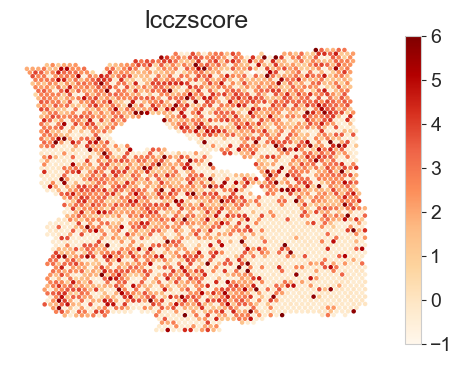

In [43]:
metadata = pd.read_csv(r'E:\spatial-domain\data\BRCA\10x visium BRCA\metadata.tsv', sep='\t')

df_singcell = pd.read_csv(r"E:\spatial-domain\results\BRCA\10x visium BRCA-HP_0000769.csv")
# labels = df_singcell['#expressedBRCAGenes']
labels = df_singcell['lcczscore']
# labels = df_singcell['lcc']

# 假设 labels 是一个数组或 Series，包含了每个点的标签值
min_label = np.min(labels)
max_label = np.max(labels)

# label_encoder = LabelEncoder()
# numeric_labels = label_encoder.fit_transform(labels)  # 转换后的标签是数字
plt.figure(figsize=(6, 4))
# 绘制散点图
scatter = plt.scatter(metadata['scaled_x'], metadata['scaled_y'], c=labels, cmap="OrRd", s=5,vmin=-1, vmax=6)
# scatter = plt.scatter(metadata['scaled_x'], metadata['scaled_y'], c=labels, cmap="viridis", s=10,vmin=-2, vmax=8)
# 显示颜色条
plt.colorbar(scatter)
# handles, _ = scatter.legend_elements()
# plt.legend(handles, label_encoder.classes_, title="Labels", borderaxespad=0.1, fontsize=10, frameon=False, bbox_to_anchor=(1, 0.8))
# plt.title("#expressedBRCAGenes")
plt.title("lcczscore",fontsize=18)
plt.grid(False)
plt.axis('off')
# plt.title("lcc")
plt.show()

In [336]:
from PIL import Image

# 打开图像文件
img = Image.open(r'E:\spatial-domain\data\BRCA\10x visium BRCA\spatial\tissue_hires_image.png')

# 沿Y轴反转图像（上下翻转）
img_flipped = img.transpose(Image.FLIP_TOP_BOTTOM)

# 保存反转后的图像
img_flipped.save(r'E:\spatial-domain\data\BRCA\10x visium BRCA\spatial\flipped_image.jpg')

# 显示图像
img_flipped.show()


In [34]:
'''空间域疾病状态的富集'''
metadata = pd.read_csv(r'E:\spatial-domain\data\BRCA\10x visium BRCA\metadata.tsv', sep='\t')

df_singcell = pd.read_csv(r"E:\spatial-domain\results\BRCA\10x visium BRCA-HP_0000769.csv")
labels = df_singcell['lcczscore']


In [35]:

# 获取df1中col1的唯一值
unique_values = metadata['annot_type'].unique()

# 遍历唯一值，获取对应的df2中的col2值
result = {}

for value in unique_values:
    # 在df1中筛选出col1为当前值的行
    filtered_df1 = metadata[metadata['annot_type'] == value]
    # 找到df2中与filtered_df1中other_col相同的行，并提取col2
    corresponding_col2 = df_singcell[df_singcell.index.isin(filtered_df1.index)]['lcczscore']
    # 将结果存储到字典中
    result[value] = corresponding_col2.tolist()

import json
# 保存到json文件
result_folder = r"..\results\BRCA"
with open(result_folder + '10x visium BRCA-HP_0000769_lcczscore.json', 'w') as file:
    json.dump(result, file, indent=4)

Invasive Tumor 0.7811018698982486
Invasive Healthy 1.0583428314019902e-58
Invasive Surrounding tumor 3.495351822099905e-14
Tumor Healthy 1.1507723965661615e-35
Tumor Surrounding tumor 5.149049553040929e-09
Healthy Surrounding tumor 0.9999981727078038


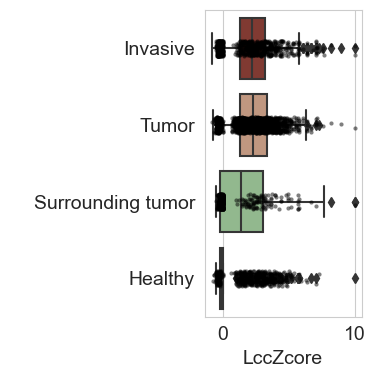

In [38]:

import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from statannot import add_stat_annotation
import pandas as pd
import numpy as np
import matplotlib.colors as mcolors
from scipy.stats import mannwhitneyu

# 将字典转换为一个 DataFrame 以便使用 seaborn 绘图
data = []
categories = []

for category, values in result.items():
    data.extend(values)
    categories.extend([category] * len(values))

# 创建 DataFrame
df = pd.DataFrame({'Domain': categories, 'LccZcore': data})

# 绘制小提琴图

# 设置全局字体大小
plt.rcParams.update({'font.size': 14})

plt.figure(figsize=(4, 4))
# 自定义颜色列表
custom_colors = ['#8D2F25', '#CB9475', '#8CBF87', '#909291']
# ax = sns.violinplot(x='Category', y='Value', data=df, palette="Set2",order=['Invasive','Tumor','Surrounding tumor','Healthy'])
ax = sns.boxplot(x='LccZcore', y='Domain', data=df, palette=custom_colors,order=['Invasive','Tumor','Surrounding tumor','Healthy'])
# ax = sns.boxplot(x='Domain', y='LccZcore', data=df, palette=custom_colors,order=['Invasive','Tumor','Surrounding tumor','Healthy'])
ax.set_ylabel(' ')
# 设置 X 轴刻度标签的显示角度
# ax.set_xticklabels(ax.get_xticklabels(), rotation=45)  # 设置为 45 度
sns.stripplot(x='LccZcore', y='Domain', data=df, color='black', jitter=True, alpha=0.5,size = 3)


# 计算每两个列表之间的 Mann-Whitney U 检验值
regions = list(set(list(df['Domain'])))
p_values = {}

# 生成颜色列表
# colors = list(mcolors.TABLEAU_COLORS.values())

# 计算每两个区域之间的U检验
for i in range(len(regions)):
    for j in range(i + 1, len(regions)):
        region_1 = regions[i]
        region_2 = regions[j]

        # 获取对应区域的数据
        data_1 = df[df['Domain'] == region_1]['LccZcore']
        data_2 = df[df['Domain'] == region_2]['LccZcore']

        # 进行Mann-Whitney U 检验（单侧检验，假设region_1 > region_2）
        stat, p = mannwhitneyu(data_1, data_2, alternative='greater')
        print(region_1, region_2, p)
        #
        # # 存储p值
        # p_values[(region_1, region_2)] = p
        #
        # # 获取两个区域的小提琴图的顶部位置
        # y_max_1 = max(data_1)
        # y_max_2 = max(data_2)
        #
        # # 计算横线的Y位置，通常稍微高于最大值
        # y_line = max(y_max_1, y_max_2) + 0.2
        #
        # # 在两个区域的顶部之间绘制横线
        # color = colors[(i + j - 1) % len(colors)]  # 使用不同颜色
        # plt.plot([i, j], [y_line, y_line], color=color, lw=1.5)
        #
        # # 计算较高的区域顶部并绘制竖线
        # if y_max_1 > y_max_2:
        #     plt.plot([i, i], [y_max_1+0.1, y_line], color=color, lw=1.5)  # 竖线连接区域1
        #     plt.plot([j, j], [y_max_1+0.1, y_line], color=color, lw=1.5)  # 竖线连接区域1
        # else:
        #     plt.plot([j, j], [y_max_2+0.1, y_line], color=color, lw=1.5)  # 竖线连接区域2
        #     plt.plot([i, i], [y_max_2+0.1, y_line], color=color, lw=1.5)  # 竖线连接区域2
        #
        # # 标注p值
        # plt.text((i + j) / 2, y_line + 0.05, f"{p:.2f}", ha='center', va='bottom', fontsize=12)

# 显示图形
# plt.title("Violin plot with Scatter and Mann-Whitney U Test p-values")
plt.tight_layout()
plt.show()

# # 打印每两个区域之间的p值
# for (region_1, region_2), p_value in p_values.items():
#     print(f"Mann-Whitney U test p-value between region {region_1} and region {region_2}: {p_value:.3f}")



0.1
Healthy 485 22 0.9999991434238595
Invasive 2027 206 0.3855250204680237
Surrounding tumor 823 93 0.09241359554946622
Tumor 463 59 0.024556983263874767
0.2
Healthy 485 35 1.0
Invasive 2027 446 0.0010714802584249024
Surrounding tumor 823 170 0.3473725997493082
Tumor 463 113 0.009238615744601756
0.30000000000000004
Healthy 485 54 1.0
Invasive 2027 699 2.928159168546732e-09
Surrounding tumor 823 231 0.9554142280424988
Tumor 463 171 0.0007923886144868483
0.4
Healthy 485 71 1.0
Invasive 2027 946 4.847634191713311e-18
Surrounding tumor 823 288 0.9998121149809516
Tumor 463 225 6.818811744525051e-05
0.5
Healthy 485 92 1.0
Invasive 2027 1177 1.0755536344582177e-26
Surrounding tumor 823 357 0.9999927877409754
Tumor 463 273 2.2938492621408678e-05
0.6000000000000001
Healthy 485 104 1.0
Invasive 2027 1443 5.75636711194167e-51
Surrounding tumor 823 409 0.9999999999967036
Tumor 463 326 5.684473676805789e-07
0.7000000000000001
Healthy 485 202 1.0
Invasive 2027 1678 6.378005859493867e-59
Surrounding 

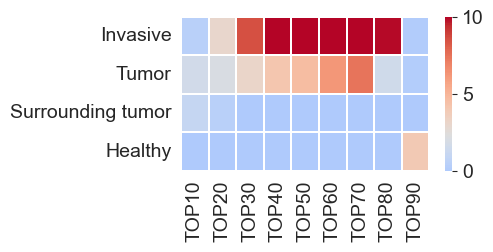

In [383]:
'''每个空间域的疾病富集情况'''
# 设置全局字体大小
plt.rcParams.update({'font.size': 14})
import scipy.stats as stats
metadata = pd.read_csv(r'E:\spatial-domain\data\BRCA\10x visium BRCA\metadata.tsv', sep='\t')

df_singcell = pd.read_csv(r"..\results\BRCA\10x visium BRCA-HP_0000769.csv")

result = []
# 富集程度
for j in range(1,10):
    degree = 0.1 * j
    print(degree)

    # 计算 col1 列的前 10% 的阈值
    threshold = df_singcell['lcczscore'].quantile(1 - degree)
    # 筛选出 col1 值最大的前 10% 数据
    top_10_percent_df = df_singcell[df_singcell['lcczscore'] >= threshold]

    top = metadata.loc[top_10_percent_df.index]
    # 计算 col1 列中所有值的数量
    top_value_counts = top["annot_type"].value_counts()
    value_counts = metadata["annot_type"].value_counts()

    value_counts.sort_index(inplace=True)
    top_value_counts.sort_index(inplace=True)

    result_j = []
    for i in  top_value_counts.index:

        # 总体大小 (100个元素)
        M = top_value_counts.sum()  # 期望成功的元素数
        N = value_counts.sum()  # 总元素数
        n = value_counts.loc[i]   # 类别A中的元素数
        k = top_value_counts.loc[i]    # 类别A中的成功元素数

        # 使用超几何分布的 survival function 计算 P(X >= 5)
        p_value = stats.hypergeom.sf(k-1, N, M, n)

        print(i,n,k,p_value)
        result_j.append(p_value)
    result.append(result_j)
result_df = pd.DataFrame(result).T
result_df.columns = [f"TOP{i}" for i in range(10, 100, 10)]

value_counts = metadata["annot_type"].value_counts()
value_counts.sort_index(inplace=True)
result_df.index = value_counts.index
result_df_sorted = result_df.reindex(['Invasive','Tumor','Surrounding tumor','Healthy'])
plt.figure(figsize=(4, 2))  # 设置图形大小
epsilon = 1e-10
g = sns.heatmap(-np.log10(result_df_sorted+epsilon), cmap='coolwarm',linewidths = 0.05,
                center = -np.log10(0.005 + epsilon))

['DUPD1', 'KANSL3', 'KAT6B', 'ARID5A', 'RP11-363D14.1', 'FER1L5']


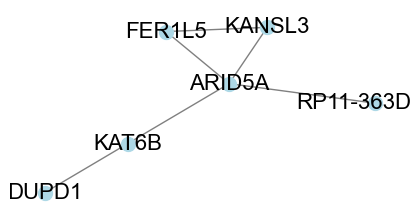

In [384]:
# 使用pandas读取疾病相关的基因文件
df = pd.read_csv(r'..\data\BRCA\disease data\Abnormality of the breastHP_0000769.tsv', sep='\t')
disease_genes = list(df["geneName"])
G = openPPI(r"E:\00_CeSOP\data\network(process_id).txt")
subgraph = nx.subgraph(G,disease_genes)
l,lcc = Lcc(G,disease_genes)
subgraph1 = nx.subgraph(subgraph,l)

# 使用 spring 布局进行绘制
plt.figure(figsize=(4, 2))
# nx.draw(subgraph, with_labels=True, node_size=300, node_color='lightblue', font_size=15, font_weight='bold', edge_color='gray')
nx.draw(subgraph1, with_labels=True, node_size=100, node_color='lightblue', font_size=16, edge_color='gray')
print(l)

In [386]:
## ARID5A基因的表达

from scipy.sparse import csr_matrix

h5_file = r"E:\spatial-domain\data\BRCA\10x visium BRCA\filtered_feature_bc_matrix.h5"

with h5py.File(h5_file, 'r') as f:
    data = f['matrix']['data'][:]
    indices = f['matrix']['indices'][:]
    indptr = f['matrix']['indptr'][:]
    genes_name = [str(x).split("'")[1] for x in f['matrix']['features']['name'][:]]

    # 假设矩阵有N行和M列，你可以从indptr的长度推算出行数
    n_rows = len(indptr) - 1  # 行数等于indptr长度减去1
    n_cols = len(genes_name)
    # 重建CSR矩阵
    sparse_matrix = csr_matrix((data, indices, indptr), shape=(n_rows, n_cols))  # 列数可以通过columns获取
    matrix = pd.DataFrame(sparse_matrix.toarray())
    matrix.columns = genes_name
    print(matrix)


      MIR1302-2HG  FAM138A  OR4F5  AL627309.1  AL627309.3  AL627309.2  \
0               0        0      0           0           0           0   
1               0        0      0           0           0           0   
2               0        0      0           0           0           0   
3               0        0      0           0           0           0   
4               0        0      0           0           0           0   
...           ...      ...    ...         ...         ...         ...   
3793            0        0      0           0           0           0   
3794            0        0      0           0           0           0   
3795            0        0      0           0           0           0   
3796            0        0      0           0           0           0   
3797            0        0      0           0           0           0   

      AL627309.5  AL627309.4  AP006222.2  AL732372.1  ...  AC133551.1  \
0              0           0           0          

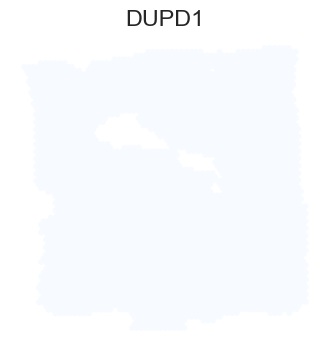

In [397]:
# 设置全局字体大小
plt.rcParams.update({'font.size': 14})
metadata = pd.read_csv(r'E:\spatial-domain\data\BRCA\10x visium BRCA\metadata.tsv', sep='\t')

# labels = matrix['ARID5A']
# labels = matrix['KAT6B']

# labels = matrix['KANSL3']
# labels = matrix['FER1L5']
labels = matrix['DUPD1']
# labels = matrix['RP11-363D14.1'  # 表达数据中不存在

# 绘制散点图
plt.figure(figsize=(4,4))
scatter = plt.scatter(metadata['scaled_x'], metadata['scaled_y'], c=labels, cmap="Blues", s=10,vmin=0.5, vmax=1)
# scatter = plt.scatter(metadata['scaled_x'], metadata['scaled_y'], c=labels, cmap="Blues", s=10)
# 显示颜色条
# plt.colorbar(scatter)
# plt.title("ARID5A")
# plt.title("KAT6B")
# plt.title("KANSL3")
# plt.title("FER1L5")
plt.title("DUPD1")

plt.grid(False)
plt.axis('off')
plt.show()


## Pancreatic cancer

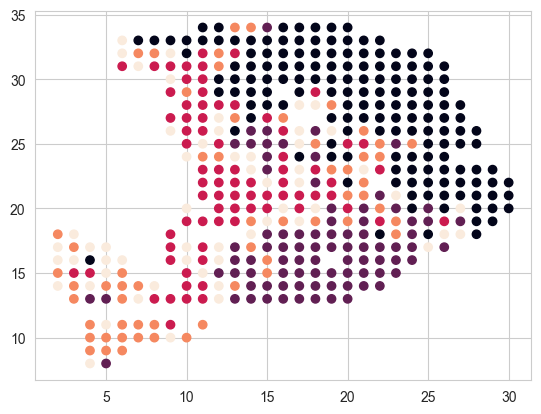

In [322]:
'''读取h5ad数据'''
import scanpy as sc

# 读取 h5ad 文件
adata = sc.read(r'E:\spatial-domain\data\Pancreatic cancer\GSM3036911_spatial_transcriptomics.h5ad')
df = pd.DataFrame(adata.obsm["spatial"])
df.columns = ['x','y']
clusters = adata.obs["leiden"]
clusters.index= range(len(clusters))

df_clusters = pd.concat([df,clusters],axis = 1)
label_encoder = LabelEncoder()
numeric_labels = label_encoder.fit_transform(df_clusters["leiden"])  # 转换后的标签是数字
plt.scatter(df_clusters["x"],df_clusters["y"],c = numeric_labels)

In [ ]:
## 读取空间表达数据
import pandas as pd
spatial_data = pd.read_csv(r"..\data\Pancreatic cancer\GSM3036911_PDAC-A-ST1-filtered.txt", sep="\t",index_col=0).T


In [ ]:
spatial_data.iloc[:]

In [327]:
# 使用pandas读取疾病相关的基因文件
# df = pd.read_csv(r'..\data\Pancreatic cancer\DOID_1793.tsv', sep='\t')
# df = pd.read_csv(r'..\data\Pancreatic cancer\HP_0006725.tsv', sep='\t')
# df = pd.read_csv(r'..\data\Pancreatic cancer\MESH_D010190.tsv', sep='\t')
df = pd.read_csv(r'..\data\Pancreatic cancer\DOID_9744.tsv', sep='\t')
disease_genes = list(df["geneName"])
G = openPPI(r"E:\00_CeSOP\data\network(process_id).txt")
subgraph = nx.subgraph(G,disease_genes)
l,lcc = Lcc(G,disease_genes)
lcc_mean,lcc_std = Lcc_mean(G,disease_genes,100)
lcczscore = lccZscore(lcc,lcc_mean,lcc_std)
lcc,lcczscore

(159, 2.245213)

In [328]:
# 遍历每一个spot
result_list = []
for index, row in spatial_data.iloc[:].iterrows():
    express_genes = row[row != 0].index.tolist()  # 获取非零值的列名
    disease_express_genes = list(set(disease_genes)&set(express_genes))
    l,lcc = Lcc(G,disease_express_genes)

    express_network_genelist = list(set(express_genes) & set(list(G.nodes())))   # 有表达的网络基因
    g = nx.subgraph(G,express_network_genelist)    # 构建有表达的子网络
    lcc_mean,lcc_std = Lcc_mean(g,disease_express_genes,10)

    lcczscore = lccZscore(lcc,lcc_mean,lcc_std)

    result_list.append([len(express_genes),len(disease_express_genes),lcc,lcczscore])
    print(index,len(express_genes),len(disease_express_genes),lcc,lcczscore)

df_singcell = pd.DataFrame(result_list)
df_singcell.columns = ["#expressedGenes","#expressedDiseaseGenes","lcc","lcczscore"]
# df_singcell.to_csv(r"..\results\Pancreatic cancer\GSM3036911-DOID_1793.csv", index=False)
df_singcell.to_csv(r"..\results\Pancreatic cancer\GSM3036911-HP_0006725.csv", index=False)
df_singcell.to_csv(r"..\results\Pancreatic cancer\GSM3036911-DOID_9744.csv", index=False)

10x10 3476 76 39 15.764816
10x13 1245 21 3 0.862044
10x14 1076 27 16 14.94597
10x15 654 15 7 14.5
10x16 509 15 5 3.283623
10x17 900 24 8 5.84274
10x19 2250 49 23 17.60132
10x20 1512 38 13 8.168874
10x24 1753 40 19 9.521574
10x25 1143 30 12 13.095801
10x26 1092 25 7 8.666667
10x27 825 16 6 6.708204
10x28 1208 25 9 4.518481
10x29 350 13 2 0.171499
10x30 472 8 3 6.333333
10x31 300 14 4 5.891883
10x32 185 8 2 2.0
10x33 404 9 3 2.412091
11x11 2022 52 27 11.095238
11x13 730 17 3 3.709704
11x14 834 22 4 5.0
11x15 502 16 6 9.389711
11x16 496 14 4 2.523573
11x17 867 22 8 8.066323
11x19 1742 41 13 9.470462
11x21 1785 39 22 19.204218
11x22 1410 32 12 6.473797
11x23 1429 34 13 20.240792
11x24 801 17 10 8.585983
11x25 487 9 2 3.0
11x26 487 11 2 1.093216
11x27 682 13 2 1.527525
11x28 886 29 11 5.579393
11x29 1002 25 9 6.313641
11x30 642 15 3 1.0
11x31 690 15 4 7.0
11x32 491 16 6 2.709356
11x33 1259 33 13 10.394155
11x34 2062 41 14 8.0
12x13 312 12 2 3.0
12x14 499 10 2 3.0
12x15 665 20 9 4.315849
12x

Text(0.5, 1.0, 'Lcczscore')

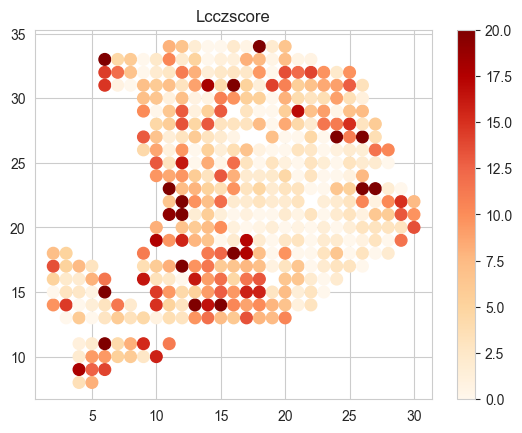

In [333]:

labels = df_singcell['lcczscore']
# 绘制空间分布图
scatter = plt.scatter(df_clusters['x'], df_clusters['y'], c = labels,cmap = 'OrRd', s=70,vmin = 0, vmax = 20)
plt.colorbar(scatter)
plt.title("Lcczscore")

## Alzheimer's disease

In [357]:
import scanpy as sc
# 读取数据
root_path = r"E:\spatial-domain\data\Alzheimer’s disease"
spatial_file_path = root_path + r"\STARmap_Zeng2023Integrative_8months-disease-replicate_1_data.h5ad"
adata = sc.read(spatial_file_path)

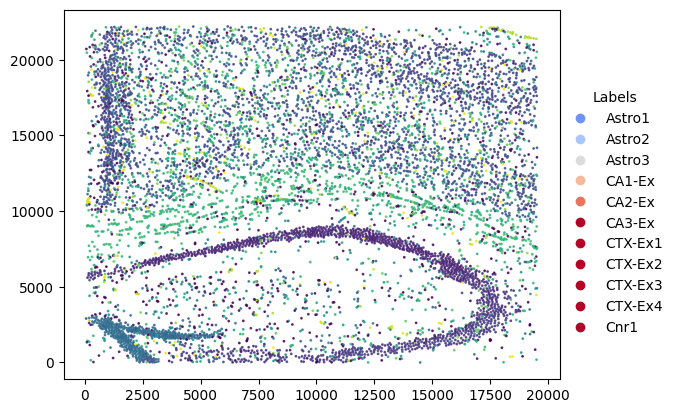

In [376]:
# 提取空间位置信息
spatial_coords = adata.obsm['spatial']
# 转为 DataFrame 并加入 obs
adata.obs[['x', 'y']] = pd.DataFrame(spatial_coords, index=adata.obs.index)

labels = adata.obs['ct_sub']
label_encoder = LabelEncoder()
numeric_labels = label_encoder.fit_transform(labels)  # 转换后的标签是数字

# 绘制空间分布图
plt.scatter(adata.obs['x'], adata.obs['y'], c = numeric_labels,cmap = 'viridis', s=1, alpha=0.8)
handles, _ = scatter.legend_elements()
plt.legend(handles, label_encoder.classes_, title="Labels", borderaxespad=0.1, fontsize=10, frameon=False, bbox_to_anchor=(1, 0.8))
plt.show()

In [408]:
Alzheimer_df = pd.read_csv(root_path + r"\Alzheimer's_diseaseDOID_10652.tsv", sep='\t')
# df = pd.read_csv(r'..\data\Breast_Neoplasms_MESH_D001943.tsv', sep='\t')
Alzheimer_genes = list(Alzheimer_df["geneName"])
l1,lcc1 = Lcc(G,Alzheimer_genes)
lcc_mean,lcc_std = Lcc_mean(G,Alzheimer_genes,100)
lcczscore = lccZscore(lcc,lcc_mean,lcc_std)
len(Alzheimer_genes),lcc1,lcczscore

(1227, 420, -11.086331)

In [420]:
express_matrix_df = pd.read_csv(root_path + r"\expression_matrix_raw.csv")

# 小鼠基因
pd.DataFrame(list(express_matrix_df["GENE"])).to_csv(root_path +"\spatial_expression_mouse_genes.csv", index=False) 

express_matrix_df.head()

KeyboardInterrupt: 

In [423]:
human_genes = list(pd.read_csv(root_path + r"\spatial_expression_human_genes.csv",index_col=0)["humanGene"])

In [402]:
# 稀疏矩阵形式
expression_matrix = adata.X

# 转换为普通的 NumPy 数组
dense_matrix = expression_matrix.toarray() if not isinstance(expression_matrix, np.ndarray) else expression_matrix

express_df = pd.DataFrame(
    dense_matrix,
    index=adata.obs_names,  # 细胞名称
    columns=adata.var_names  # 基因名称
)

In [407]:
adata

AnnData object with n_obs × n_vars = 8186 × 2766
    obs: 'ct_top', 'ct_sub', 'sample', 'leiden', 'x', 'y'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'leiden', 'leiden_colors', 'log1p', 'moranI', 'neighbors', 'pca', 'spatial_neighbors', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial'
    varm: 'PCs'
    obsp: 'connectivities', 'distances', 'spatial_connectivities', 'spatial_distances'

In [406]:
adata.var_names

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
       ...
       '2756', '2757', '2758', '2759', '2760', '2761', '2762', '2763', '2764',
       '2765'],
      dtype='object', length=2766)

In [404]:
# 遍历每一个spot
result_list = []
for index, row in express_df.iloc[:10].iterrows():
    express_genes = row[row != 0].index.tolist()  # 获取非零值的列名
    brca_express_genes = list(set(brca_genes)&set(express_genes))
    l,lcc = Lcc(G,brca_express_genes)
    
    express_network_genelist = list(set(express_genes) & set(list(G.nodes())))   # 有表达的网络基因   
    g = nx.subgraph(G,express_network_genelist)    # 构建有表达的子网络
    lcc_mean,lcc_std = Lcc_mean(g,brca_express_genes,20)
    
    lcczscore = lccZscore(lcc,lcc_mean,lcc_std)

    result_list.append([len(express_genes),len(brca_express_genes),lcc,lcczscore])
    print(index,len(express_genes),len(brca_express_genes),lcc,lcczscore)

df_singcell = pd.DataFrame(result_list)
df_singcell.columns = ["#expressedGenes","#expressedBRCAGenes","lcc","lcczscore"]
df_singcell.to_csv(r"..\results\Alzheimer’s disease\DOID_10652_STARmap_Zeng2023Integrative_8months-disease-replicate_1_data.csv", index=False)

59045 64 0 0 0
59051 69 0 0 0
59052 56 0 0 0
59055 101 0 0 0
59056 80 0 0 0
59058 69 0 0 0
59059 58 0 0 0
59060 61 0 0 0
59061 73 0 0 0
59062 109 0 0 0


## Prostate_Cancer

D:\Anaconda\Anaconda3\lib\site-packages\anndata\_core\anndata.py:1832: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


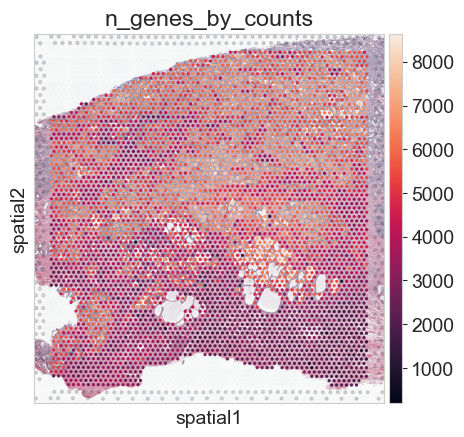

In [399]:
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

adata = sc.read_visium(r"E:\spatial-domain\data\prostate cancer\HumanProstateCancerFFPE", 
                       count_file=r'Visium_FFPE_Human_Prostate_Cancer_filtered_feature_bc_matrix.h5',
                       load_images=True)

sc.pp.calculate_qc_metrics(adata, inplace=True)
sc.pl.spatial(adata, img_key='hires', color="n_genes_by_counts")


In [398]:
from scipy.sparse import csr_matrix
h5_file = r"E:\spatial-domain\data\prostate cancer\HumanProstateCancerFFPE\Visium_FFPE_Human_Prostate_Cancer_filtered_feature_bc_matrix.h5"

with h5py.File(h5_file, 'r') as f:
    data = f['matrix']['data'][:]
    indices = f['matrix']['indices'][:]
    indptr = f['matrix']['indptr'][:]
    genes_name = [str(x).split("'")[1] for x in f['matrix']['features']['name'][:]]
    print(data)
    print(indices)
    print(indptr)
    
    # 假设矩阵有N行和M列，你可以从indptr的长度推算出行数
    n_rows = len(indptr) - 1  # 行数等于indptr长度减去1
    n_cols = len(genes_name)
    # 重建CSR矩阵
    sparse_matrix = csr_matrix((data, indices, indptr), shape=(n_rows, n_cols))  # 列数可以通过columns获取
    matrix = pd.DataFrame(sparse_matrix.toarray()) 
    matrix.columns = genes_name
    print(matrix)

[1 1 1 ... 2 1 2]
[    1     5     9 ... 17927 17940 17942]
[       0     4349    10110 ... 20688381 20691604 20695894]
      SAMD11  NOC2L  KLHL17  PLEKHN1  PERM1  HES4  ISG15  AGRN  RNF223  \
0          0      1       0        0      0     1      0     0       0   
1          1      1       0        0      0     2      0     2       0   
2          0      7       0        0      0     2      0     0       0   
3          0      3       0        1      0     2      1     2       0   
4          0      1       0        0      0     2      2     2       0   
...      ...    ...     ...      ...    ...   ...    ...   ...     ...   
4366       0      0       0        0      0     3      0     2       0   
4367       0      3       0        0      0     2      2     1       0   
4368       1      0       0        0      0     0      0     1       0   
4369       0      0       0        0      0     0      1     0       0   
4370       0      0       0        0      0     1      0     2    

In [450]:

disease_df = pd.read_csv(r"E:\spatial-domain\data\prostate cancer\DOID_10283.tsv", sep='\t')
# disease_df = pd.read_csv(r"E:\spatial-domain\data\prostate cancer\MESH_D017430.tsv", sep='\t')
# df = pd.read_csv(r'..\data\Breast_Neoplasms_MESH_D001943.tsv', sep='\t')
disease_genes = list(disease_df["geneName"])
l1,lcc1 = Lcc(G,disease_genes)
lcc_mean,lcc_std = Lcc_mean(G,disease_genes,100)
lcczscore = lccZscore(lcc,lcc_mean,lcc_std)
len(disease_genes),lcc1,lcczscore

(581, 125, -3.457298)

In [451]:


# 遍历每一个spot
result_list = []
for index, row in matrix.iloc[:].iterrows():
    express_genes = row[row != 0].index.tolist()  # 获取非零值的列名
    disease_express_genes = list(set(disease_genes)&set(express_genes))
    l,lcc = Lcc(G,disease_express_genes)
    
    express_network_genelist = list(set(express_genes) & set(list(G.nodes())))   # 有表达的网络基因   
    g = nx.subgraph(G,express_network_genelist)    # 构建有表达的子网络
    lcc_mean,lcc_std = Lcc_mean(g,disease_express_genes,10)
    
    lcczscore = lccZscore(lcc,lcc_mean,lcc_std)

    result_list.append([len(express_genes),len(disease_express_genes),lcc,lcczscore])
    print(index,len(express_genes),len(disease_express_genes),lcc,lcczscore)

df_singcell = pd.DataFrame(result_list)
df_singcell.columns = ["#expressedGenes","#expressedBRCAGenes","lcc","lcczscore"]
df_singcell.to_csv(r"..\results\postate disease\FFPE_Human_Prostate_Cancer_DOID_10283.csv", index=False)



0 4349 97 29 5.431726
1 5761 123 40 5.709052
2 5726 104 21 4.330156
3 6375 134 42 4.952806
4 4248 88 27 4.468151
5 2588 50 16 5.25879
6 6711 134 46 7.946197
7 4168 102 19 1.775695
8 3077 68 19 5.295366
9 6555 132 41 7.518716
10 3615 91 21 2.594695
11 2397 51 5 0.289122
12 3144 71 8 0.0
13 6261 131 41 3.130973
14 5602 109 34 4.945052
15 5963 115 30 3.455304
16 5933 123 48 5.305204
17 1891 53 17 1.935934
18 2238 39 4 1.24939
19 1661 44 5 0.461144
20 6231 129 50 4.905779
21 5594 112 25 1.993125
22 2619 60 4 -0.118493
23 6019 120 25 4.687788
24 3765 89 21 5.715476
25 3626 78 7 -0.181108
26 3411 72 9 0.900998
27 1899 47 11 4.358899
28 4258 93 33 11.16636
29 6130 122 35 8.215838
30 3783 85 16 0.942052
31 3964 78 24 9.491773
32 5744 121 39 3.711293
33 4467 101 13 1.74658
34 2833 66 15 3.153748
35 6105 120 25 2.446471
36 4703 103 21 2.221893
37 5726 126 47 5.242017
38 5021 106 20 1.996833
39 5911 125 23 2.731113
40 5299 113 36 14.524945
41 6282 131 44 4.403855
42 1761 39 3 0.229416
43 4313 95 

In [413]:
df_singcell["lcczscore"].min()

-1.837117

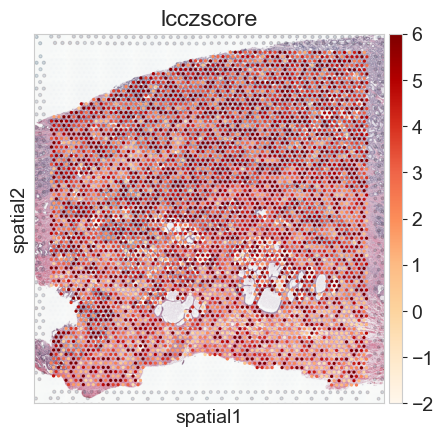

In [414]:
df_singcell = pd.read_csv(r"..\results\Postate_Cancer\FFPE_Human_Prostate_Cancer_DOID_10283.csv")
adata.obs['lcczscore'] = list(df_singcell["lcczscore"])
adata.obs['lcc'] = list(df_singcell["lcc"])
# adata.obs['#expressedGenes'] = list(df_singcell["#expressedGenes"])
# adata.obs['#expressedDiseaseGenes'] = list(df_singcell["#expressedBRCAGenes"])
sc.pl.spatial(adata, img_key='hires', color="lcczscore", color_map='OrRd', vmin=-2, vmax=6)
# sc.pl.spatial(adata, img_key='hires', color="lcc", color_map='viridis')
# sc.pl.spatial(adata, img_key='hires', color="#expressedGenes", color_map='viridis')
# sc.pl.spatial(adata, img_key='hires', color="#expressedDiseaseGenes", color_map='viridis')

In [476]:
# disease_df = pd.read_csv(r"E:\spatial-domain\data\prostate cancer\DOID_10283.tsv", sep='\t')
disease_df = pd.read_csv(r"E:\spatial-domain\data\prostate cancer\MESH_D017430.tsv", sep='\t')
disease_genes = list(disease_df["geneName"])
l1,lcc1 = Lcc(G,disease_genes)
lcc_mean,lcc_std = Lcc_mean(G,disease_genes,100)
lcczscore = lccZscore(lcc,lcc_mean,lcc_std)
# len(disease_genes),lcc1,lcczscore

# 遍历每一个spot
result_list = []
for index, row in matrix.iloc[:].iterrows():
    express_genes = row[row != 0].index.tolist()  # 获取非零值的列名
    disease_express_genes = list(set(disease_genes)&set(express_genes))
    l,lcc = Lcc(G,disease_express_genes)
    
    express_network_genelist = list(set(express_genes) & set(list(G.nodes())))   # 有表达的网络基因   
    g = nx.subgraph(G,express_network_genelist)    # 构建有表达的子网络
    lcc_mean,lcc_std = Lcc_mean(g,disease_express_genes,10)
    
    lcczscore = lccZscore(lcc,lcc_mean,lcc_std)

    result_list.append([len(express_genes),len(disease_express_genes),lcc,lcczscore])
    print(index,len(express_genes),len(disease_express_genes),lcc,lcczscore)

df_singcell = pd.DataFrame(result_list)
df_singcell.columns = ["#expressedGenes","#expressedBRCAGenes","lcc","lcczscore"]
df_singcell.to_csv(r"..\results\postate disease\FFPE_Human_Prostate_Cancer_MESH_D017430.csv", index=False)

0 4349 7 2 0
1 5761 8 2 3.0
2 5726 9 2 0
3 6375 11 3 2.654954
4 4248 10 2 2.0
5 2588 8 1 -0.333333
6 6711 9 2 2.0
7 4168 9 2 3.0
8 3077 9 3 3.709704
9 6555 9 2 0
10 3615 8 2 0
11 2397 5 1 0
12 3144 7 1 -0.333333
13 6261 11 3 6.333333
14 5602 8 2 0
15 5963 9 2 3.0
16 5933 8 2 3.0
17 1891 5 1 -0.333333
18 2238 6 1 0
19 1661 5 1 -0.333333
20 6231 9 2 2.0
21 5594 8 2 3.0
22 2619 7 1 0
23 6019 9 3 6.333333
24 3765 9 2 3.0
25 3626 8 2 3.0
26 3411 8 2 3.0
27 1899 5 1 -0.333333
28 4258 7 2 0
29 6130 8 2 0
30 3783 9 2 1.527525
31 3964 8 2 0
32 5744 9 2 3.0
33 4467 7 1 0
34 2833 7 1 0
35 6105 9 2 2.0
36 4703 11 2 1.527525
37 5726 7 1 0
38 5021 8 2 3.0
39 5911 10 2 2.0
40 5299 9 2 2.0
41 6282 8 2 3.0
42 1761 6 1 -0.333333
43 4313 9 2 0
44 5637 9 2 0
45 3664 8 2 1.527525
46 5667 9 2 1.527525
47 3273 7 1 0
48 6458 10 2 3.0
49 5703 7 1 0
50 2103 5 1 0
51 6378 9 2 0
52 4914 7 2 3.0
53 5715 8 2 2.0
54 3004 7 1 0
55 5892 10 2 3.0
56 4938 9 2 2.0
57 5618 10 2 3.0
58 6210 9 2 1.527525
59 5674 8 2 3.0
60 

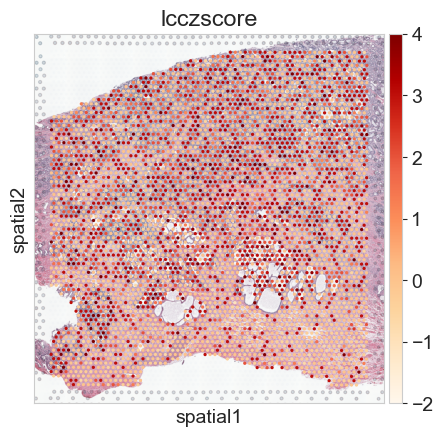

In [416]:
df_singcell = pd.read_csv(r"..\results\Postate_Cancer\FFPE_Human_Prostate_Cancer_MESH_D017430.csv")
adata.obs['lcczscore'] = list(df_singcell["lcczscore"])
# adata.obs['lcc'] = list(df_singcell["lcc"])
# adata.obs['#expressedGenes'] = list(df_singcell["#expressedGenes"])
# adata.obs['#expressedDiseaseGenes'] = list(df_singcell["#expressedBRCAGenes"])
sc.pl.spatial(adata, img_key='hires', color="lcczscore", color_map='OrRd', vmin=-2, vmax=4)
# sc.pl.spatial(adata, img_key='hires', color="lcc", color_map='viridis')
# sc.pl.spatial(adata, img_key='hires', color="#expressedGenes", color_map='viridis')
# sc.pl.spatial(adata, img_key='hires', color="#expressedDiseaseGenes", color_map='viridis')

## Ovarian_Cancer

D:\Anaconda\Anaconda3\lib\site-packages\anndata\_core\anndata.py:1832: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


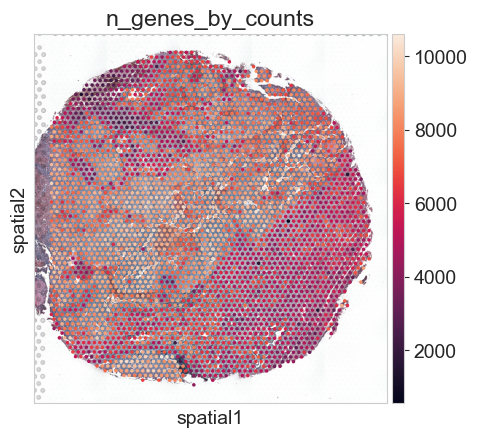

In [417]:
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

adata = sc.read_visium(r"E:\spatial-domain\data\Ovarian_Cancer", 
                       count_file=r'Visium_FFPE_Human_Ovarian_Cancer_filtered_feature_bc_matrix.h5',
                       load_images=True)

sc.pp.calculate_qc_metrics(adata, inplace=True)
sc.pl.spatial(adata, img_key='hires', color="n_genes_by_counts")

In [418]:
from scipy.sparse import csr_matrix
h5_file = r"E:\spatial-domain\data\Ovarian_Cancer\Visium_FFPE_Human_Ovarian_Cancer_filtered_feature_bc_matrix.h5"

with h5py.File(h5_file, 'r') as f:
    data = f['matrix']['data'][:]
    indices = f['matrix']['indices'][:]
    indptr = f['matrix']['indptr'][:]
    genes_name = [str(x).split("'")[1] for x in f['matrix']['features']['name'][:]]
    print(data)
    print(indices)
    print(indptr)
    
    # 假设矩阵有N行和M列，你可以从indptr的长度推算出行数
    n_rows = len(indptr) - 1  # 行数等于indptr长度减去1
    n_cols = len(genes_name)
    # 重建CSR矩阵
    sparse_matrix = csr_matrix((data, indices, indptr), shape=(n_rows, n_cols))  # 列数可以通过columns获取
    matrix = pd.DataFrame(sparse_matrix.toarray()) 
    matrix.columns = genes_name
    print(matrix)

[1 2 1 ... 1 2 1]
[    0     1     2 ... 17925 17927 17930]
[       0     6534    12803 ... 23867635 23877537 23884278]
      SAMD11  NOC2L  KLHL17  PLEKHN1  PERM1  HES4  ISG15  AGRN  RNF223  \
0          1      2       1        0      0     1      1     3       0   
1          0      1       0        0      0     0      7     5       0   
2          0      4       0        0      0     3     14     6       0   
3          0      2       0        0      0     0     12     4       0   
4          0      3       0        0      0     2     13     6       0   
...      ...    ...     ...      ...    ...   ...    ...   ...     ...   
3450       0      2       0        1      0     3     21     5       0   
3451       1      2       0        0      0     1      8     0       0   
3452       1      1       0        0      0     2      3     1       0   
3453       0      4       0        0      0     1     45    11       0   
3454       0      0       0        1      0     0     16     0    

In [485]:
# disease_df = pd.read_csv(r"E:\spatial-domain\data\prostate cancer\DOID_10283.tsv", sep='\t')
disease_df = pd.read_csv(r"E:\spatial-domain\data\Ovarian_Cancer\DOID_2394.tsv", sep='\t')
disease_genes = list(disease_df["geneName"])
l1,lcc1 = Lcc(G,disease_genes)
lcc_mean,lcc_std = Lcc_mean(G,disease_genes,100)
lcczscore = lccZscore(lcc,lcc_mean,lcc_std)
# len(disease_genes),lcc1,lcczscore

# 遍历每一个spot
result_list = []
for index, row in matrix.iloc[:].iterrows():
    express_genes = row[row != 0].index.tolist()  # 获取非零值的列名
    disease_express_genes = list(set(disease_genes)&set(express_genes))
    l,lcc = Lcc(G,disease_express_genes)
    
    express_network_genelist = list(set(express_genes) & set(list(G.nodes())))   # 有表达的网络基因   
    g = nx.subgraph(G,express_network_genelist)    # 构建有表达的子网络
    lcc_mean,lcc_std = Lcc_mean(g,disease_express_genes,10)
    
    lcczscore = lccZscore(lcc,lcc_mean,lcc_std)

    result_list.append([len(express_genes),len(disease_express_genes),lcc,lcczscore])
    print(index,len(express_genes),len(disease_express_genes),lcc,lcczscore)

df_singcell = pd.DataFrame(result_list)
df_singcell.columns = ["#expressedGenes","#expressedBRCAGenes","lcc","lcczscore"]
df_singcell.to_csv(r"..\results\Ovarian_Cancer\FFPE_Human_Ovarian_Cancer_DOID_2394.csv", index=False)

0 6534 19 2 0.620174
1 6269 23 2 0.816497
2 8812 28 2 0.267261
3 7646 26 2 -0.267261
4 8470 25 2 0.904534
5 7505 24 2 0.267261
6 4940 15 2 1.0
7 5554 16 2 1.224745
8 8611 32 4 2.225996
9 6905 25 2 -0.185695
10 5720 20 2 1.527525
11 6651 24 2 0.0
12 5382 17 2 0.542326
13 7201 21 2 1.527525
14 8716 27 2 1.0
15 2918 6 1 0
16 5353 21 2 0.436436
17 6791 21 2 3.0
18 5446 19 2 1.224745
19 6125 20 2 1.0
20 8718 35 4 2.176627
21 6471 19 2 0.468521
22 3027 7 2 0
23 6526 24 2 0.229416
24 5683 16 1 -0.468521
25 5904 12 2 2.0
26 8326 29 2 0.468521
27 5605 13 2 1.527525
28 8745 27 2 0.468521
29 7700 26 3 2.030259
30 8961 35 4 1.626978
31 6667 25 2 0.745356
32 5585 16 2 1.0
33 7877 25 2 0.603023
34 5497 15 2 2.0
35 5539 14 2 1.527525
36 5628 18 2 1.224745
37 5835 18 2 1.224745
38 4917 20 2 0.745356
39 6151 24 3 2.236068
40 9470 38 3 1.603567
41 5643 17 2 1.0
42 2547 6 1 -0.333333
43 8168 30 2 -0.333333
44 8486 33 4 2.064742
45 8621 25 2 0.468521
46 9354 35 4 2.528103
47 8426 27 2 -0.267261
48 7997 25

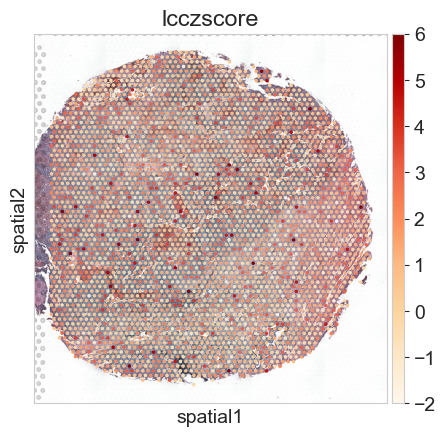

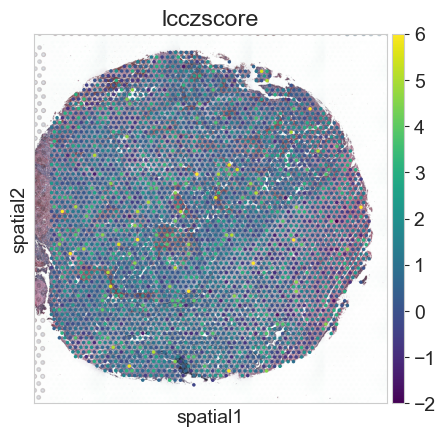

In [427]:
df_singcell = pd.read_csv(r"..\results\Ovarian_Cancer\FFPE_Human_Ovarian_Cancer_DOID_2394.csv")
adata.obs['lcczscore'] = list(df_singcell["lcczscore"])
# adata.obs['lcc'] = list(df_singcell["lcc"])
# adata.obs['#expressedGenes'] = list(df_singcell["#expressedGenes"])
# adata.obs['#expressedDiseaseGenes'] = list(df_singcell["#expressedBRCAGenes"])
sc.pl.spatial(adata, img_key='hires', color="lcczscore", color_map='OrRd', vmin=-2, vmax=6)
sc.pl.spatial(adata, img_key='hires', color="lcczscore", color_map='viridis', vmin=-2, vmax=6)
# sc.pl.spatial(adata, img_key='hires', color="lcc", color_map='viridis')
# sc.pl.spatial(adata, img_key='hires', color="#expressedGenes", color_map='viridis')
# sc.pl.spatial(adata, img_key='hires', color="#expressedDiseaseGenes", color_map='viridis')